In [2]:
import gzip
import csv
import random
from copy import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
from greenpyce.feature_engineering import TargetEncoder
from greenpyce.feature_engineering import onehot
from greenpyce.feature_engineering import RankCategorical
from greenpyce.feature_engineering import LabelCount
from greenpyce.feature_engineering import time_count_between_dates
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# The universe and everything else
random.seed(42)

/home/bartuka/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/bartuka/miniconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Helper functions

In [3]:
def complete_report(y_test, y_pred):
    print("*********************************")
    print("Accuracy: {0:.2f}".format(accuracy_score(y_test, y_pred)))
    print("Precision: {0}".format(metrics.precision_score(y_test, y_pred)))
    print("Recall: {0}".format(metrics.recall_score(y_test, y_pred)))
    print("F1-Score: {0}".format(metrics.f1_score(y_test, y_pred)))
    conf_m = confusion_matrix(y_test, y_pred)
    print(conf_m)
    try: 
        print("Roc Area: {0}".format(metrics.roc_auc_score(y_test, y_pred))) 
        roc_curve_label(y_test, y_pred)
    except:
        print("--")
    print("*********************************")
    
    return metrics.roc_auc_score(y_test, y_pred)
        
def roc_curve_label(y_test, y_pred):
    plt.figsize=(10,6)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='RT + LR')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
    
def expand_date_info(df, columns, hour_feats=False):
    """
    Create year, month, day, hour and minute from a datetime column.
    """
    for column in columns:
        df[column + "_DAY"] = df[column].apply(lambda x: x.day)
        df[column + "_MONTH"] = df[column].apply(lambda x: x.month)
        df[column + "_YEAR"] = df[column].apply(lambda x: x.year)
        if hour_feats:
            df[column + "_HOUR"] = df[column].apply(lambda x: x.hour)

    return df

def parse_date(x):
    text = ""
    year = int(x / 10000)
    month = int((x % 10000) / 100)
    day = (x % 100)
    text = str(year) + "-" + str(month) + "-" + str(day)
    
    return text


def build_kaggle_submission(model, df_test, features, filename="my_submission"):
    """
    Build a compressed Kaggle Submission
    
    df_test : Dataframe com os dados de teste
    model : Modelo treinado
    features : Lista de features usadas para o treinamento
    filename : Nome do arquivo de submissão
    """
    
    preds = model.predict_proba(df_test[features])
    preds = preds[:, 1]
    
    with gzip.open(filename + '.csv.gz', 'wt') as outf:
        fo = csv.writer(outf, lineterminator='\n')
        fo.writerow(["sample_id", "is_listened"])       
        for i, pred in enumerate(preds):
            fo.writerow([i, pred])

## GridSearch definition

In [5]:
def optimize_model(model, X, y, params_grid, cross_validation):
    model_tmp = copy(model)
    search = GridSearchCV(estimator=model_tmp, param_grid=params_grid, cv=cross_validation, verbose=True)
    search.fit(X, y)
    
    print("Best score: ", search.best_score_)
    print("Best params: ", search.best_params_)
    
    # input the best params inside the model and return the model with the right params
    best_params = search.best_params_
    model_tmp = model_tmp.set_params(**best_params)
    return model_tmp, best_params

## Feature engineering

### User specific features

In [51]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")
nmidia_feats = pd.read_csv("../features/nmidia_feats.csv", sep=";")

In [57]:
nmidia_feats["user_id"] = nmidia_feats["index"]

In [59]:
nmidia_feats.__len__()

1319

In [54]:
user_features_used = ["user_id", "nartist_with_flow", "nartist_with_flow_listened", "nmidia_regular_listened", "nmidia_regular",
                      "nmidia_with_flow", "nartist_regular_listened", "nartist_regular", "nmidia_with_flow_listened"]
df_user_feats = nmidia_feats[user_features_used]

In [55]:
df_train = pd.merge(df_train, df_user_feats, on="user_id")
df_test = pd.merge(df_test, df_user_feats, on="user_id")
df_test.head()

,sample_id,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,...,artist_id,user_age,nartist_with_flow,nartist_with_flow_listened,nmidia_regular_listened,nmidia_regular,nmidia_with_flow,nartist_regular_listened,nartist_regular,nmidia_with_flow_listened
0,1,2744,1479317140,876497,99692,1,19851231,0,0,307,...,26,28,0,0,1,1,0,1,1,0
1,3,2744,1478457729,876500,99692,1,19851231,2,1,265,...,26,30,0,0,0,1,0,0,1,0
2,4,2744,1480448560,876504,99692,1,19851231,2,1,356,...,26,29,1,1,7,7,4,1,1,4
3,5,2744,1479410530,876497,99692,1,19851231,0,0,307,...,26,21,0,0,1,1,0,1,1,0
4,12,18,1480623636,3084955,298859,1,20090413,0,0,131,...,7085,22,1,1,2,2,2,1,1,1


In [36]:
df_train["year"] = df_train["release_date"].apply(lambda x: x // 10000)
df_train.drop(df_train[df_train["year"] > 2017].index , inplace=True)
df_train["text"] = df_train["release_date"].apply(lambda x : parse_date(x))
df_train["text"] = df_train["text"].apply(lambda x : pd.to_datetime(x))
df_train["release_date"] = df_train["text"]
expand_date_info(df_train, ["release_date"]).head()


df_test["year"] = df_test["release_date"].apply(lambda x : x // 10000)
df_test.drop(df_test[df_test["year"] > 2017].index , inplace=True)
df_test["text"] = df_test["release_date"].apply(lambda x : parse_date(x))
df_test["text"] = df_test["text"].apply(lambda x : pd.to_datetime(x))
df_test["release_date"] = df_test["text"]
expand_date_info(df_test, ["release_date"]).head()

,sample_id,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,...,nmidia_regular,nmidia_with_flow,nartist_regular_listened,nartist_regular,nmidia_with_flow_listened,year,text,release_date_DAY,release_date_MONTH,release_date_YEAR
0,1,2744,1479317140,876497,99692,1,1985-12-31,0,0,307,...,1,0,1,1,0,1985,1985-12-31,31,12,1985
1,3,2744,1478457729,876500,99692,1,1985-12-31,2,1,265,...,1,0,0,1,0,1985,1985-12-31,31,12,1985
2,4,2744,1480448560,876504,99692,1,1985-12-31,2,1,356,...,7,4,1,1,4,1985,1985-12-31,31,12,1985
3,5,2744,1479410530,876497,99692,1,1985-12-31,0,0,307,...,1,0,1,1,0,1985,1985-12-31,31,12,1985
4,12,18,1480623636,3084955,298859,1,2009-04-13,0,0,131,...,2,2,1,1,1,2009,2009-04-13,13,4,2009


In [37]:
df_train.drop(["text", "release_date"], axis=1, inplace=True)
df_test.drop(["text", "release_date"], axis=1, inplace=True)

In [38]:
df_train["media_duration"] = df_train["media_duration"].apply(lambda x: round(x / 60.0))
df_test["media_duration"] = df_test["media_duration"].apply(lambda x : round(x / 60.0))

In [39]:
cols_for_target_encoder = ["genre_id", "context_type", "user_id", "media_id", "media_duration"]
cols_for_onehot = ["platform_name", "platform_family", "listen_type", "user_gender", "user_age"]
cols_for_rank = ["artist_id"]

target = "is_listened"

In [40]:
te = TargetEncoder(cols_for_target_encoder, "is_listened", inplace=True)
te.fit(df_train)

te.transform(df_train)
te.transform(df_test)

In [41]:
rc = RankCategorical(cols_for_rank)
rc.fit(df_train)
rc.transform(df_train)
rc.transform(df_test)

In [42]:
df_train = onehot(df_train, cols_for_onehot)
df_test = onehot(df_test, cols_for_onehot)

In [46]:
df_test["listen_type_1"] = 1

In [47]:
features = [col for col in df_train.columns.values if col != target]
features

['genre_id',
 'ts_listen',
 'media_id',
 'album_id',
 'context_type',
 'media_duration',
 'user_id',
 'artist_id',
 'nartist_with_flow',
 'nartist_with_flow_listened',
 'nmidia_regular_listened',
 'nmidia_regular',
 'nmidia_with_flow',
 'nartist_regular_listened',
 'nartist_regular',
 'nmidia_with_flow_listened',
 'year',
 'release_date_DAY',
 'release_date_MONTH',
 'release_date_YEAR',
 'platform_name_1',
 'platform_name_2',
 'platform_family_1',
 'platform_family_2',
 'listen_type_1',
 'user_gender_1',
 'user_age_19',
 'user_age_20',
 'user_age_21',
 'user_age_22',
 'user_age_23',
 'user_age_24',
 'user_age_25',
 'user_age_26',
 'user_age_27',
 'user_age_28',
 'user_age_29',
 'user_age_30']

In [48]:
df_test.columns

Index(['sample_id', 'genre_id', 'ts_listen', 'media_id', 'album_id',
       'context_type', 'media_duration', 'user_id', 'artist_id',
       'nartist_with_flow', 'nartist_with_flow_listened',
       'nmidia_regular_listened', 'nmidia_regular', 'nmidia_with_flow',
       'nartist_regular_listened', 'nartist_regular',
       'nmidia_with_flow_listened', 'year', 'release_date_DAY',
       'release_date_MONTH', 'release_date_YEAR', 'platform_name_1',
       'platform_name_2', 'platform_family_1', 'platform_family_2',
       'user_gender_1', 'user_age_19', 'user_age_20', 'user_age_21',
       'user_age_22', 'user_age_23', 'user_age_24', 'user_age_25',
       'user_age_26', 'user_age_27', 'user_age_28', 'user_age_29',
       'user_age_30', 'listen_type_1'],
      dtype='object')

## RandomForestClassifier params to be used in GridSearch

parametros utilizados no modelo:

    - n_estimators = numero de arvores
    - criterion = funcao que mede a qualidade dos splits. Opções são gini que mede a impureza Gini e "entropy" que mede o ganho de informação.
    - max_features = o numero de features que deve ser considerada para cada split
    - max_depth = profundidade das arvores
    - oob_score = utiliza leave-one-out para calcular acurácia de validação fora da amostra   

In [24]:
grid_params = {"n_estimators": [12, 15, 18], 
               "criterion": ["gini", "entropy"],
               "max_features": ["auto", "sqrt", None],
               "max_depth": [15, 20, 30, None]
               }

grid_params = {"n_estimators": [18],
               "criterion": ["entropy"],
               "max_features": [None],
               "max_depth": [None]
               }

In [26]:
X = df_train[features]
y = df_train[target]

model = RandomForestClassifier(oob_score=True, n_jobs = 10)
best_model, best_params = optimize_model(model, X, y, grid_params, 2)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/bartuka/miniconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/bartuka/miniconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/bartuka/miniconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/bartuka/miniconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min finished


Best score:  0.7342572465677567
Best params:  {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'n_estimators': 18}


/home/bartuka/miniconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/bartuka/miniconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


## Aplicação do modelo RandomForest com os melhores parametros encontrados pelo GridSearchCV

/home/bartuka/miniconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/bartuka/miniconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


*********************************
Accuracy: 0.81
Precision: 0.8623415540439303
Recall: 0.8636718327951116
F1-Score: 0.8630061807810996
[[ 57109  22969]
 [ 22712 143886]]
Roc Area: 0.7884194974060725


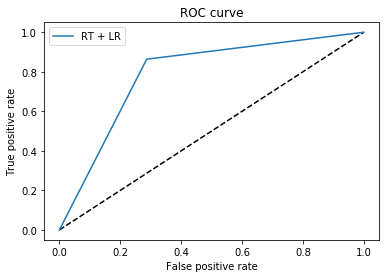

*********************************


0.78841949740607253

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[target], test_size = 0.2)
best_model.fit(X_train, y_train)
best_model.score(X_test, y_test)
complete_report(y_test, best_model.predict(X_test))

In [49]:
build_kaggle_submission(best_model, df_test, features, filename="my_submission")

In [50]:
len(df_test)

1319